### Основные Методы по Работе с Временными Рядами 

Рассмотрим стандартный Pipeline по работе с временными рядами. Будем рассматривать ВР продаж в магазинах

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import statsmodels.api as sm

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, TimeSeriesSplit

import warnings

SEED = 42
warnings.filterwarnings('ignore')

In [2]:
cd D:\GIT_REPOES\ML_DL_Scripts\Time_Series\data

D:\GIT_REPOES\ML_DL_Scripts\Time_Series\data


In [3]:
# Загрузка Данных (при работе с ВР лучше использовать время как индекс)
store_sales_1 = pd.read_csv('store_sales_1.csv', parse_dates=['date'], index_col='date')
store_sales_2 = pd.read_csv('store_sales_2.csv', parse_dates=['date'], index_col='date') 

store_sales_1.head()

,sales
date,
2013-01-01,6577.80500
2013-01-02,6577.80500
2013-01-03,5691.44700
2013-01-04,4825.64699
2013-01-05,5694.05600


### Визуализация Ряда 

In [344]:
def plot_sereis(series, x_label=None, y_label=None):
    """
    Plots timeseries
    
    series: DataFrame
    
    x_label: str
        x axis name 
    
    """
    plt.figure(figsize=(20,8))
    plt.plot(series)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True);

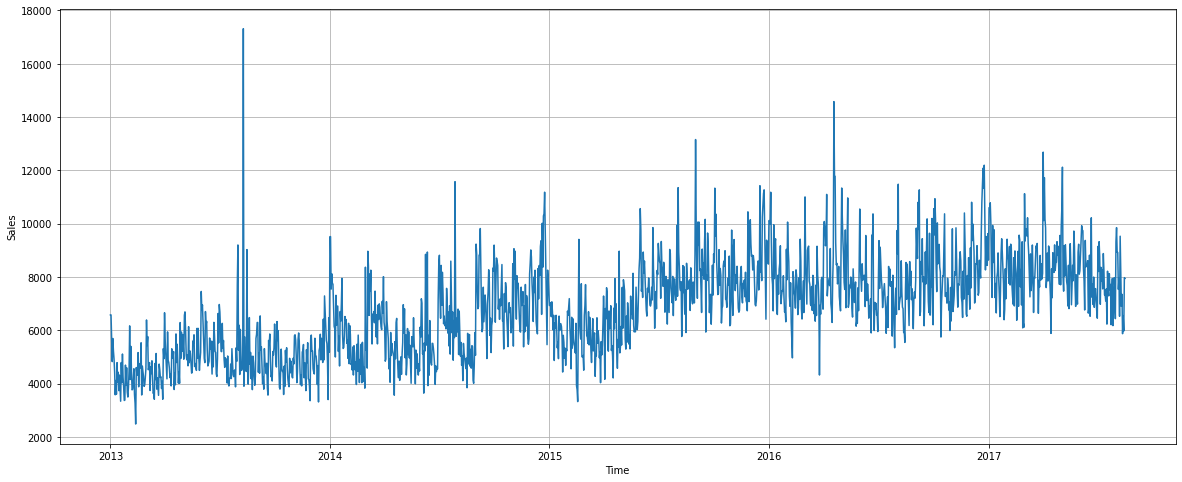

In [5]:
plot_sereis(store_sales_1['sales'], x_label='Time', y_label='Sales')

### Основные Метрики 


In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

# MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Декомпозиция Временного Ряда 

In [7]:
def plot_decomposition(series, figsize = (12, 9), grid=True):
    """
    Plots timeseries decomposition (trend, seasonal, residuals)
    
    series: DataFrame
    
    figsize: tuple 
        Figure size
        
    grid: bool
        Wether to plot grid or not
    
    """
    ts_compnts = sm.tsa.seasonal_decompose(series, period=360)
    titles = ['Origianl', 'Trend', 'Seasonal', 'Resid']

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=figsize)
    plt.tight_layout()
    
    ax[0].set_title('Time Series Decomposition')    
    ax[0].plot(series)
    ax[1].plot(ts_compnts.trend)
    ax[2].plot(ts_compnts.seasonal)
    ax[3].plot(ts_compnts.resid)
    
    for indx, title in enumerate(titles):
        ax[indx].set_ylabel(title)
        ax[indx].grid(True)

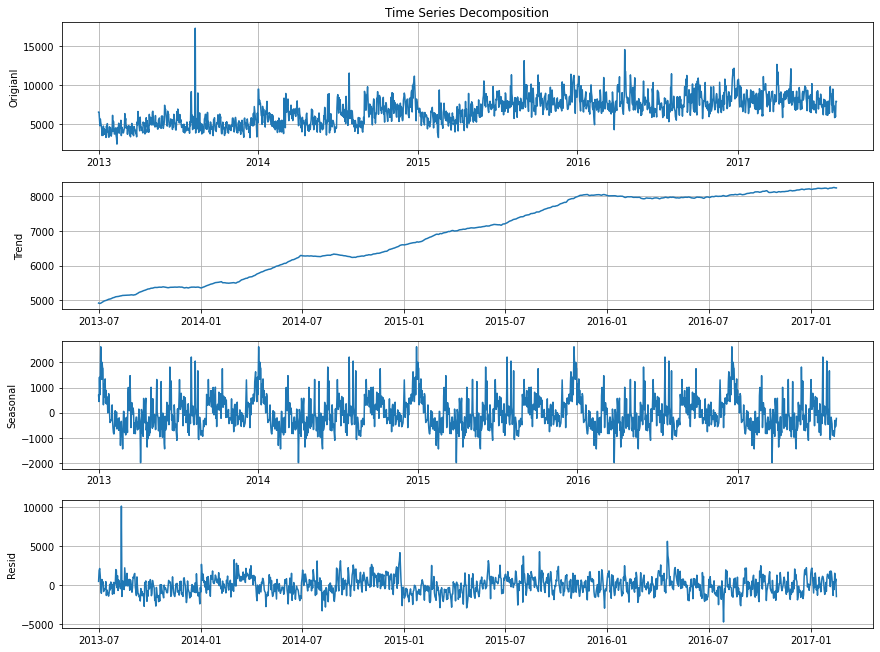

In [8]:
plot_decomposition(store_sales_1)

In [326]:
# Let's consider only first 150 points of the series 
series = store_sales_1.iloc[:150]

### ACF and PACF Functions

In [328]:
def plot_acf_pacf(series, lags=30, figsize=(12, 7)):
    """
    Plots autocorrelation and partial autocorrelation functions 
    ts: pd.Series
        Time Series
    lags: int 
        Max number of lags to plot
    figsize: tuple 
        Figure size
    Returns:
    -------
    None
    """
    plt.figure(figsize=figsize)
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(series.values, lags=lags, ax=ax)
    plt.grid(True)
    
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(series.values, lags=lags, ax=ax)
    plt.grid(True)

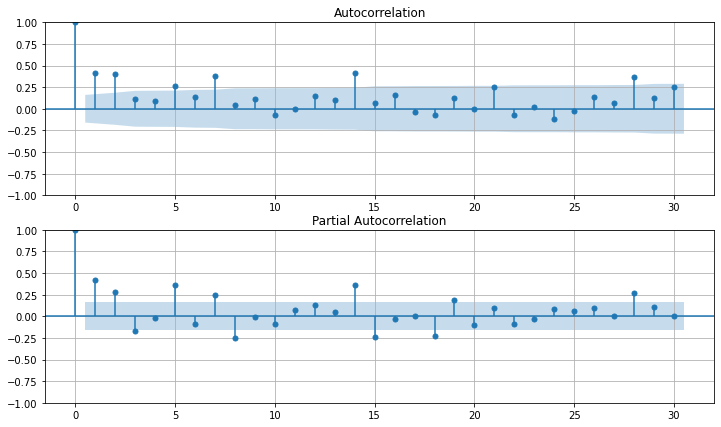

In [329]:
plot_acf_pacf(series)

### Стационарность Временного Ряда 

Для плучения стационарности можно использовать:
- Стабилизация дисперсии (Бокс-Кокс)
- Сезонные и первые разности 

In [346]:
from statsmodels.tsa.stattools import adfuller

# Критерий Дики-Фуллера (H0 - исходный ряд нестационарный)
print("Diki-Fuller Criterion: p=%f" % adfuller(series)[1])

Diki-Fuller Criterion: p=0.570931


Optimal Lambda: 0.157901


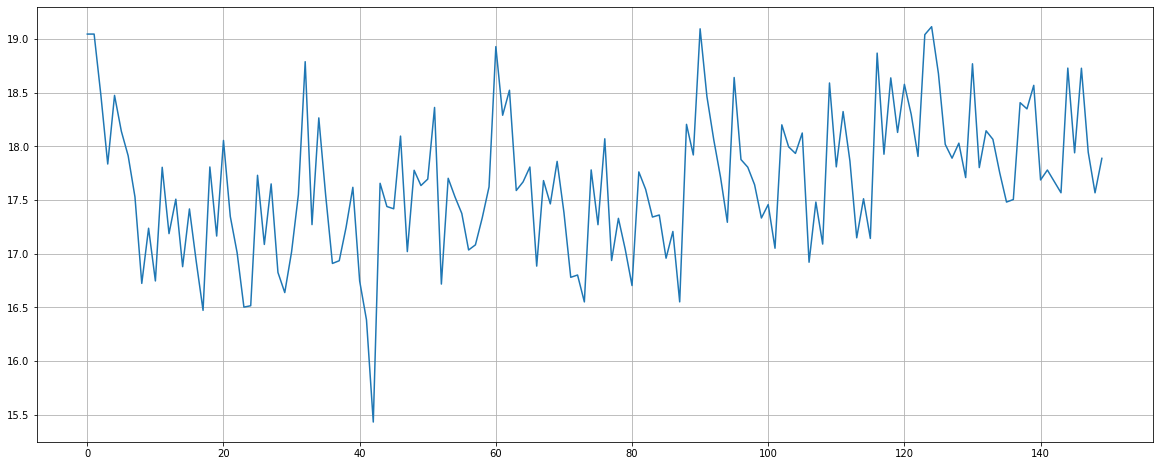

In [347]:
from scipy.stats import boxcox


# Стабилизация дисперсии (Бокс-Кокс)
box_cox_ts, lmbda = boxcox(np.squeeze(series.values))
print("Optimal Lambda: %f" %lmbda)

plot_sereis(box_cox_ts)

### Moving Average
Самая простая модель, **обычно используется для выявления тренда или сглаживания временного ряда**

In [10]:
def plot_moving_average(series, window, metric, figsize=(12, 6), plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    Plots moving average results
    
    series: DataFrame
    
    window: int
        Window size
        
    metric: func (callable)
        e.g. MSE, MAE ... that measure error between original series and calculated trend 
        
    plot_intervals: bool 
        Wether to plot confidence intervals or not 
        
    scale: float
        e.g. 2/3 sigma rule 
        
    plot_anomalies: bool 
        Wether to plot anomalies or not 
    
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=figsize)
    plt.plot(rolling_mean, "g", label="Rolling Mean Trend")
    plt.title("Moving average\n Window Size = {}".format(window))

    # Confidence Intervals for Smoothed Values 
    if plot_intervals:
        error = metric(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (error + scale * deviation)
        upper_bound = rolling_mean + (error + scale * deviation)
        plt.plot(upper_bound, "r--", label='Upper Bound')
        plt.plot(lower_bound, "r--", label='Lower Bound')
        plt.fill_between(x=series.index, y1=np.squeeze(upper_bound.values), y2=np.squeeze(lower_bound.values), alpha=0.2, color="grey") 

        # Anomalies (Values that cross Confidence Intervals)
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bound] = series[series < lower_bound]
            anomalies[series > upper_bound] = series[series > upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

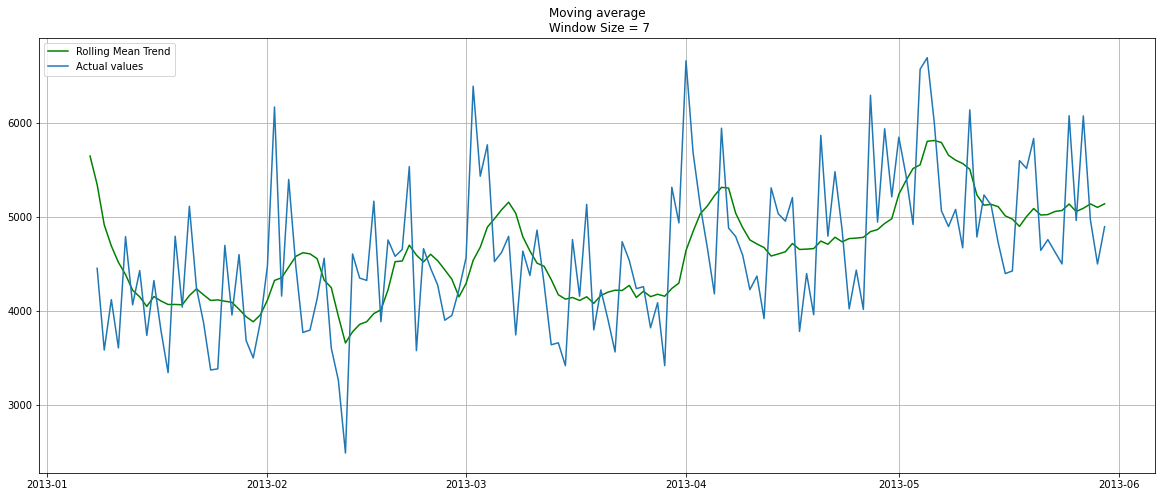

In [11]:
# Smoothed by 7 days - Weekly Trend
plot_moving_average(series, window=7, metric=mean_absolute_error, figsize=(20, 8))

Получили неплохое представление тренда ВР

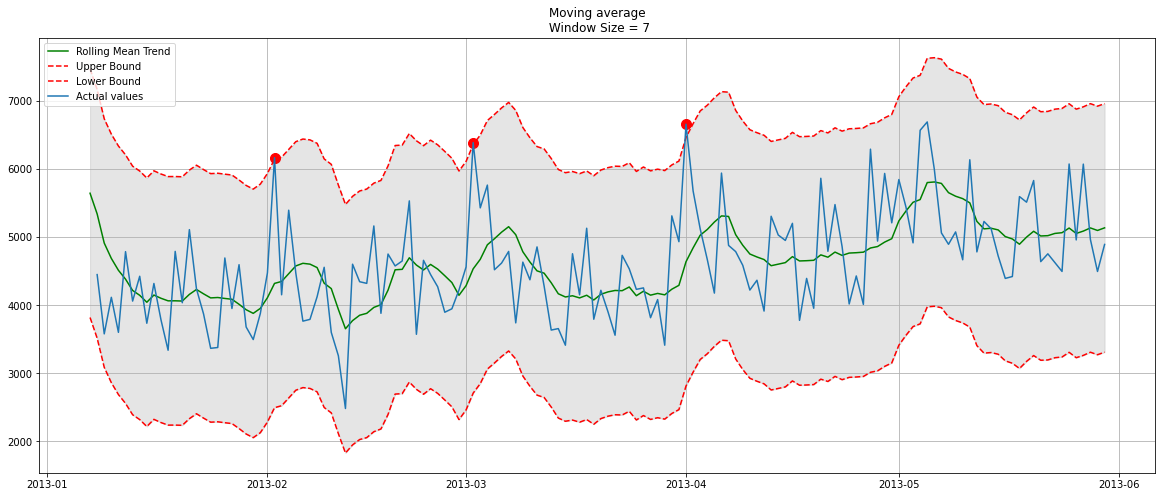

In [12]:
plot_moving_average(series,
                    window=7,
                    metric=mean_absolute_error,
                    figsize=(20, 8),
                    plot_intervals=True,
                    scale=1.96,
                    plot_anomalies=True)

Объекты,  которые помечены как аномалии - такими не являются (FP), так как мы используем модель скользящего среднего, а это очень простоя модель.

Ошибка прогноза велика и данная **модель просто не может учесть, например месячную сезонность, поэтому в данных пиках ВР мы видим аномальные значения.**

Для учета данных зависимостей необходима модель посложнее 

### Exponential Smoothing 
Аналогичен подходу скользящего среднего, только теперь мы сглаживаем с весами которые экспоненциально уменьшаются/увеличиваются чем глубже мы движемся в прошлое.

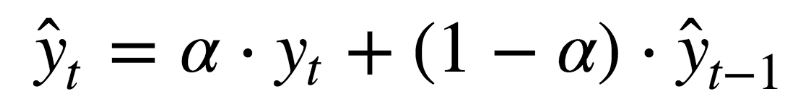

Чем меньше параметр сглаживания альфа, тем больший акцент придаётся прошлым значениям ряда (их вклад становится сильней)

**Данный алгоритм позволяет предсказывать на 1 значение вперёд**

In [13]:
def exponential_smoothing(series, alpha):
    """
    Exponential smoothing algorithm 
    
    """
    result = [series.iloc[0][0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n][0] + (1 - alpha) * result[n-1])
    return result


# Визуализация (удобно для подбора оптимального альфа)
def plot_exponential_smoothing(series, alphas, figsize=(12, 6)):
    """
    Plots exponential smoothing using different alphas 
    
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=figsize)
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

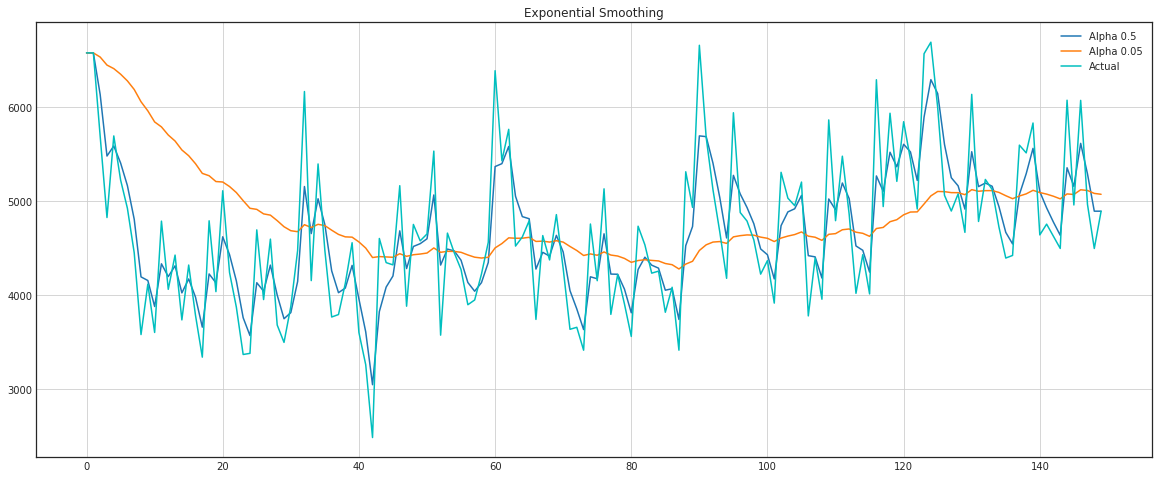

In [14]:
plot_exponential_smoothing(series, alphas=[0.5, 0.05], figsize=(20, 8))

Использование альфа равным 0.5 очень неплохо моделирует ряд. Сезонность учитывается лучше, определим аномалии снова 

In [15]:
# Определим функцию для построения Exponential Smoothing и обнаружения аномалий с уже известным значением альфа
def plot_exponential_smoothing_with_anomalies(series, smoothing_func, metric, scale=1.96, figsize=(12, 6), plot_intervals=True, plot_anomalies=True, title=None):
    """
    Plots exponential/double exponential smoothing using certain hyperparameters combinations 
    
    series: DataFrame
    
    smoothing_func: callable
        Functions to be used (e.g. exponential smoothing or double exponential smoothing)
        
    metric: callable
        Metric function
        
    scale: float
        e.g. 2/3 sigma rule 
    
    plot_intervals: bool 
        Wether to plot confidence intervals or not 
        
    plot_anomalies: bool 
        Wether to plot anomalies or not 
    
    """
    exp_smoothing_res = np.array(smoothing_func) 
    exp_smoothing_df = pd.DataFrame(exp_smoothing_res, index=series.index)  # to see the date on x axis
    
    plt.figure(figsize=figsize)
    plt.plot(exp_smoothing_df, 'g', label='Exponential Trend')        
    plt.plot(series, label="Actual Values")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    
    # Confidence Intervals for Smoothed Values 
    if plot_intervals:
        error = metric(series, exp_smoothing_df)
        deviation = np.std(np.squeeze(series.values) - exp_smoothing_res)
        lower_bound = exp_smoothing_df - (error + scale * deviation)
        upper_bound = exp_smoothing_df + (error + scale * deviation)
        plt.plot(upper_bound, "r--", label='Upper Bound')
        plt.plot(lower_bound, "r--", label='Lower Bound')
        plt.fill_between(x=series.index, y1=np.squeeze(upper_bound.values), y2=np.squeeze(lower_bound.values), alpha=0.2, color="grey") 
        
        # Anomalies (Values that cross Confidence Intervals)
        if plot_anomalies:
            # Column names must match, otherwise not working 
            upper_bound.rename(columns={0: series.columns[0]}, inplace=True)
            lower_bound.rename(columns={0: series.columns[0]}, inplace=True)
            
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)            
            anomalies[series < lower_bound] = series[series < lower_bound]
            anomalies[series > upper_bound] = series[series > upper_bound]
            plt.plot(anomalies, "ro", markersize=10)

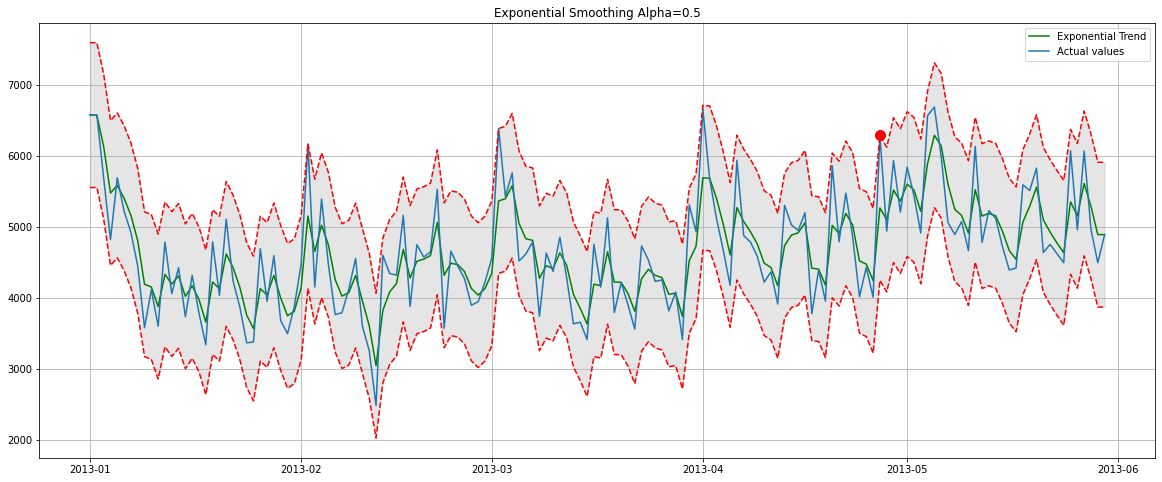

In [16]:
plot_exponential_smoothing_with_anomalies(series,
                                          smoothing_func=exponential_smoothing(series, alpha=0.5),
                                          metric=mean_absolute_error,
                                          scale=1.96,
                                          figsize=(20, 8),
                                          plot_intervals=True,
                                          plot_anomalies=True,
                                          title="Exponential Smoothing Alpha=0.5")

### Double Exponential Smoothing 
Позволяет учитывать не только тренд, но и уровень ВР. 

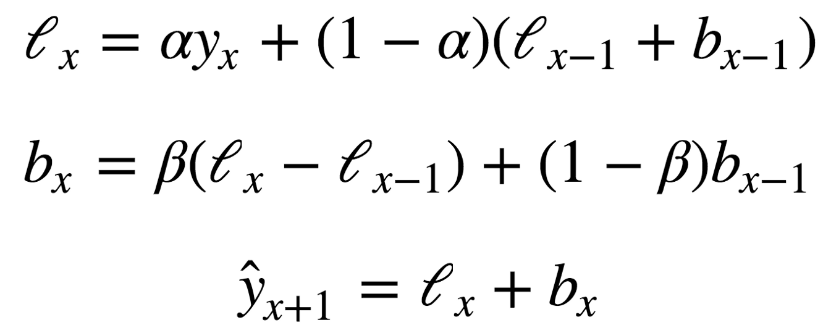

**Модель позволяет предсказывать на 2 значения вперёд**

In [17]:
def double_exponential_smoothing(series, alpha, beta):
    """
    Double exponential smoothing algorithm
    
    series: DataFrame
    
    alpha: float
        Smoothing parameter for level
        
    beta: float
        Smoothing parameter for trend
        
    """
    # First value is same as series
    result = [series.iloc[0][0]]
    for n in range(1, len(series)): # add len(series)+1 for forecasting on a single step in the future 
        if n == 1:
            level, trend = series.iloc[0][0], series.iloc[1][0] - series.iloc[0][0]
        # Forecasting
        if n >= len(series): 
            value = result[-1]
        else:
            value = series.iloc[n][0]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    return result


def plot_double_exponential_smoothing(series, alphas, betas, figsize=(20, 8)):
    """
    Plots double exponential smoothing with different alphas and betas

    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=figsize)
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, Beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

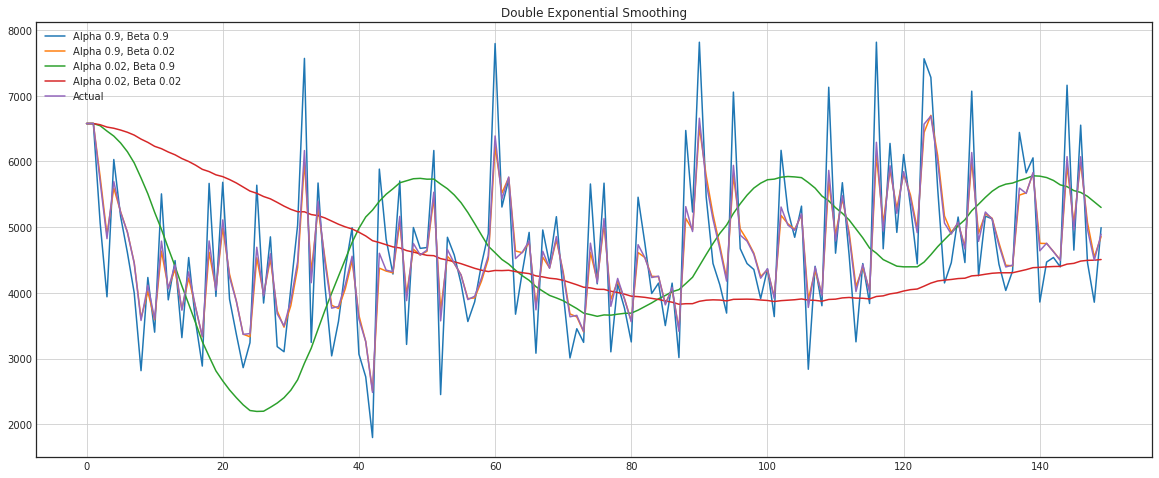

In [18]:
plot_double_exponential_smoothing(series, alphas=[0.9, 0.02], betas=[0.9, 0.02])

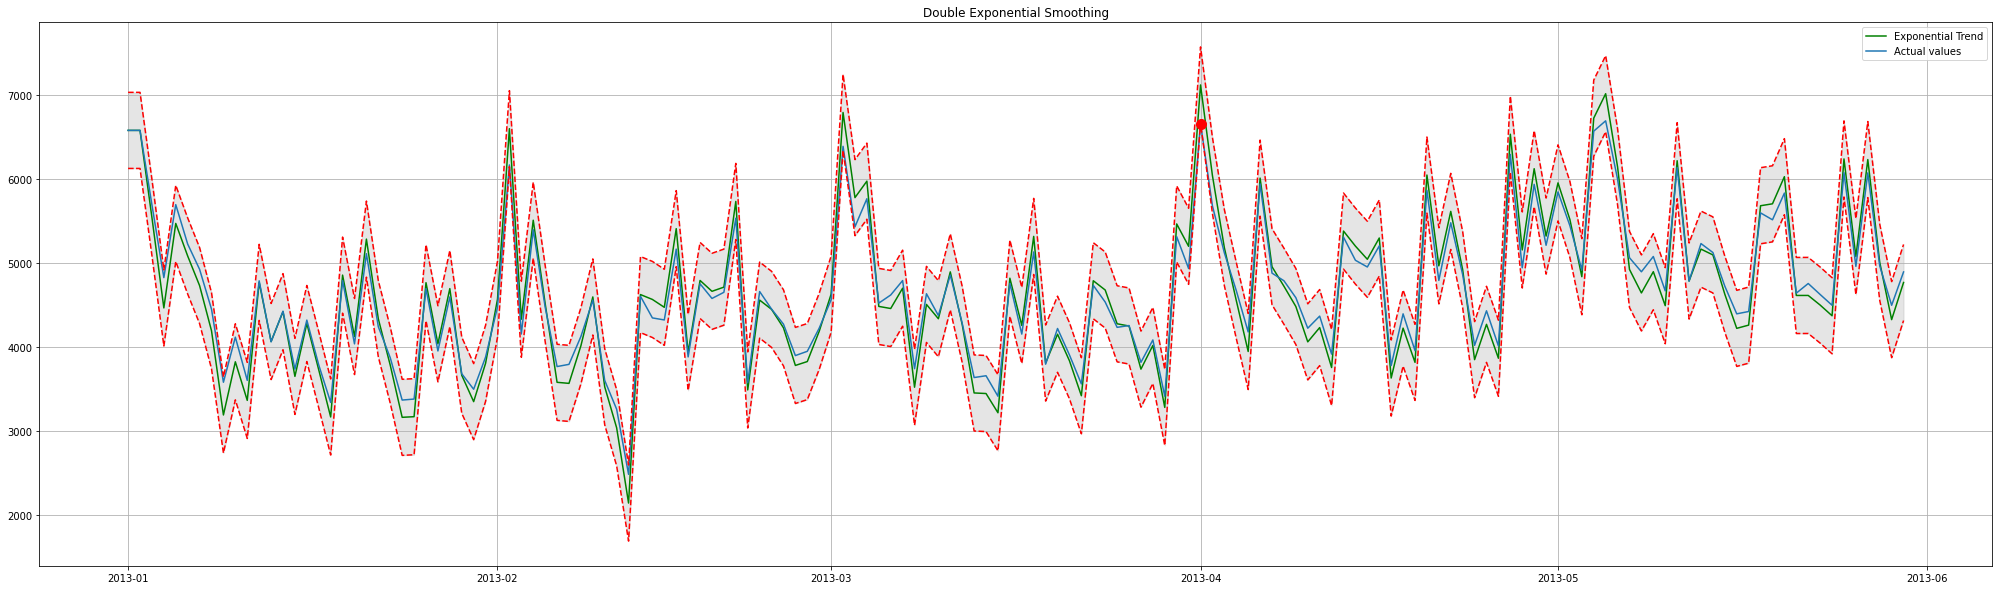

In [19]:
plot_exponential_smoothing_with_anomalies(series,
                                          smoothing_func=double_exponential_smoothing(series, alpha=0.9, beta=0.3),
                                          metric=mean_absolute_error,
                                          scale=1.96,
                                          figsize=(35, 10),
                                          plot_intervals=True,
                                          plot_anomalies=True,
                                          title="Double Exponential Smoothing")

### Triple Exponential Smoothing 
Позволяет учитывать все 3 составляющие ВР: уровень, тренд и сезонность. 

Сезонная компонента позволяет объяснять/предсказывать повторяющиеся колебания вокруг тренда. Для этого лишь необходимо указать длину сезона (например, недельная - 7 дней)

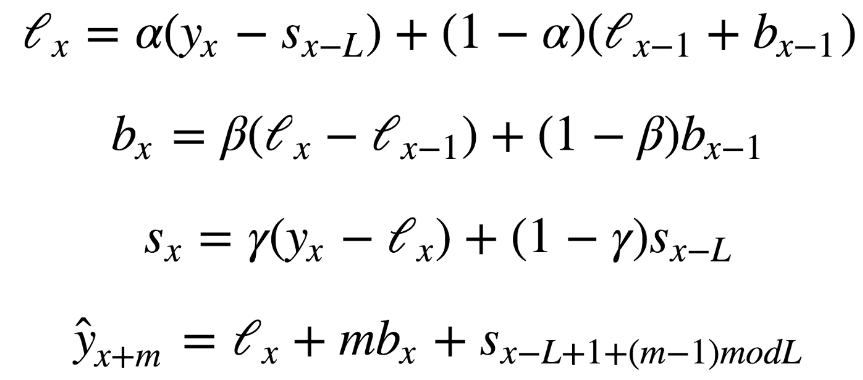

**Не применять модель для ВР не имеющих сезонную составляющую**

**Модель позволяет предсказывать на N значений вперёд**

Данная модель уже сложней и имеет ряд гиперпараметров которые необходимо подобрать

**Важно**

Мы не используем `GridSearch` т.к. мы используем модель из модуля `statsmodels` (просто не сможем использовать модель, поэтому определили свои функции)

In [39]:
from scipy.optimize import minimize 

from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [99]:
def get_holt_cv_score(model_params, series, components_type, metric, season_len, n_splits):
    """
    Runs Time Series CV for a given model parameters list
        
    model_params: list
        Parameters for the model (alpha, beta and gamma )
        
    series: DataFrame
        
    components_type: list
        Type of a trend (always first value) and seasonal components ('additive' or 'multiplicative')
        
    metric: callable
        MAPE, MSE ...
        
    season_len: int 
        Season length 
        
    cv_splits: int 
        Number of CV splits 
        
    """
    cv_errors = []
    ts_values = series.values
    trend, seasonal = components_type
    alpha, beta, gamma = model_params
    
    # Define TS Cross Validation 
    timeseries_cv = TimeSeriesSplit(n_splits=n_splits)
    
    # Iterate over folds (train and test contain list of indeces)
    for train_indxs, test_indxs in timeseries_cv.split(ts_values):
        model = ExponentialSmoothing(endog=ts_values[train_indxs], trend=trend, seasonal=seasonal, seasonal_periods=season_len)
        model = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        
        actual = ts_values[test_indxs]
        preds = model.forecast(steps=len(test_indxs))
        error = metric(actual, preds)
        cv_errors.append(error)
        
    return np.mean(cv_errors)

def optimize_holt_hyperparams(model_params, series, components_type, metric, season_len, n_splits, show_cv_score=True):
    """
    Find the best alpha, beta and gamma values for Holt-Winters model 
    using minimize function from scipy.optimize module and get_holt_cv_score function
    
    model_params: list
    
    series: DataFrame
    
    components_type: list
        Type of trend (always first value) and seasonal components ('additive' or 'multiplicative')
        
    metric: callable
        MAPE, MSE ...
        
    season_len: int 
        Season length 
        
    cv_splits: int 
        Number of CV splits 
    
    Note:
        minimize returns a dictionary and the optimal hyperparameters are located in x key  
    
    """
        
    # Minimize the loss 
    opt_params = minimize(get_holt_cv_score, 
                          x0=model_params,
                          args=(series, components_type, metric, season_len, n_splits),
                          method="TNC",
                          bounds=((0, 1), (0, 1), (0, 1)))
    
    # Found hyperparameters
    alpha_opt, beta_opt, gamma_opt = opt_params.x
    
    print(f'Optimization Successful: {opt_params.success}')
    print(f'Optimal Alpha: {alpha_opt}\nOptimal Beta: {beta_opt}\nOptimal Gamma: {gamma_opt}\n')
    
    trend, seasonal = components_type
    model = ExponentialSmoothing(endog=series, trend=trend, seasonal=seasonal, seasonal_periods=season_len)
    model = model.fit(smoothing_level=alpha_opt, smoothing_trend=beta_opt, smoothing_seasonal=gamma_opt)
    
    if show_cv_score:
        cv_score = get_holt_cv_score(model_params=[alpha_opt, beta_opt, gamma_opt],
                                     series=series,
                                     components_type=components_type,
                                     metric=metric,
                                     season_len=season_len,
                                     n_splits=n_splits)
        print(round(cv_score, 2))
    
    return model 

In [322]:
# Разобьем на train и test 
train_data = series[:-14]
test_data = series[-14:]

In [323]:
holt_model = optimize_holt_hyperparams(model_params=[0.1, 0.2, 0.3],
                                       series=train_data, 
                                       components_type=['mul', 'mul'],
                                       metric=mean_absolute_percentage_error,
                                       season_len=7,
                                       n_splits=3,
                                       show_cv_score=True)

Optimization Successful: False
Optimal Alpha: 0.08425586120626266
Optimal Beta: 0.04993858337402346
Optimal Gamma: 0.3240331302416378

16.99


In [324]:
def plot_holt_forecast(model, train_data, metric, test_data=None, scale=1.96, figsize=(12, 6), plot_intervals=True, plot_anomalies=True, title=None):
    """
    Plots Holt-Winters model forecast using already fitted model
    
    series: DataFrame
            
    metric: callable
        Metric function
        
    scale: float
        e.g. 2/3 sigma rule 
    
    plot_intervals: bool 
        Wether to plot confidence intervals or not 
        
    plot_anomalies: bool 
        Wether to plot anomalies or not 
    
    """
    # Create DataFrame because train_data is a DataFrame as well 
    forecast_train = model.predict(train_data.index[0], train_data.index[-1])
    forecast_train_df = pd.DataFrame(forecast_train, index=forecast_train.index)
    
    if test_data is not None:
        forecast_test = model.predict(test_data.index[0], test_data.index[-1])
        forecast_test_df = pd.DataFrame(forecast_test, index=forecast_test.index)
        main_df = pd.concat([forecast_train_df, forecast_test_df])
    
    plt.figure(figsize=figsize)
    plt.plot(train_data, label='Actual')        
    plt.plot(main_df, 'g', label="Model")
    
    plt.axvline(train_data.index[-1], ymin=0.05, ymax=0.95,  ls='--', color='purple', lw=2.5)
    title = ' '.join([word.capitalize() for word in metric.__name__.split('_')]) + ' Train' + f''
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    
    # Calculate the intervals using only train data 
    if plot_intervals:
        error = metric(train_data.values, forecast_train_df.values)
        deviation = np.std(train_data.values - forecast_train_df.values)
        lower_bound = main_df - (error + scale * deviation)
        upper_bound = main_df + (error + scale * deviation)
       
        plt.plot(lower_bound, "r--", label='Lower Bound')
        plt.plot(upper_bound, "r--", label='Upper Bound')
        plt.fill_between(x=main_df.index, y1=np.squeeze(upper_bound.values), y2=np.squeeze(lower_bound.values), alpha=0.2, color="grey") 
        
        title = ' '.join([word.capitalize() for word in metric.__name__.split('_')]) + ' Train ' + f'{round(error, 2)}'
        plt.title(title)    
        
        # Anomalies (Values that cross Confidence Intervals)
        if plot_anomalies:
            # Column names must match, otherwise not working 
            upper_bound.rename(columns={0: train_data.columns[0]}, inplace=True)
            lower_bound.rename(columns={0: train_data.columns[0]}, inplace=True)
            
            # Track anomalies only for train (thus select boundaries only for train part, otherwise not working)
            upper_bound = upper_bound.loc[train_data.index]
            lower_bound = lower_bound.loc[train_data.index]
            
            anomalies = pd.DataFrame(index=train_data.index, columns=train_data.columns)            
            anomalies[train_data < lower_bound] = train_data[train_data < lower_bound]
            anomalies[train_data > upper_bound] = train_data[train_data > upper_bound]
            plt.plot(anomalies, "ro", markersize=10)

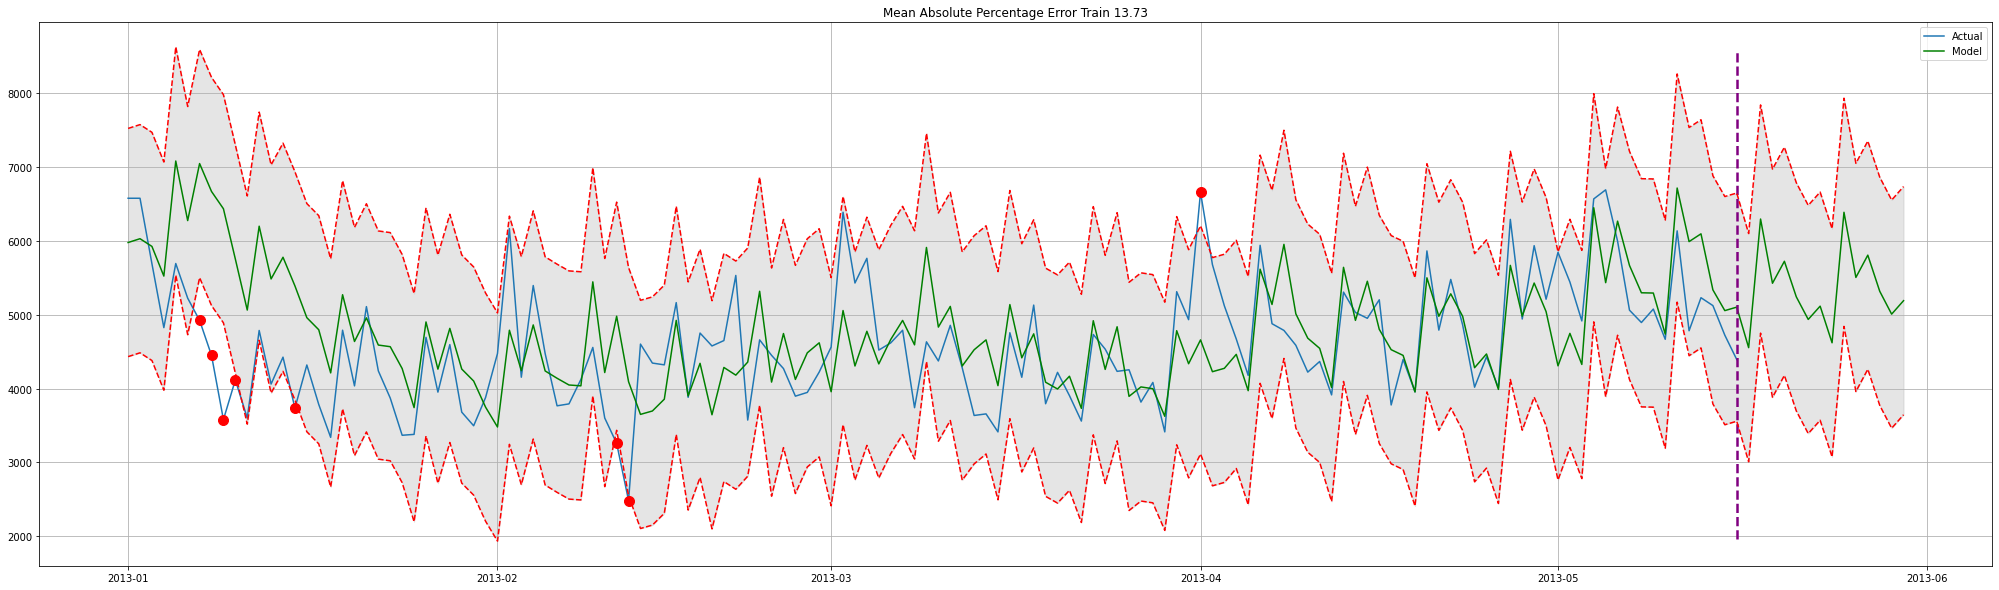

In [325]:
plot_holt_forecast(model=holt_model,
                   train_data=train_data,
                   test_data=test_data,
                   metric=mean_absolute_percentage_error,
                   scale=1.96,
                   figsize=(35, 10),
                   plot_intervals=True,
                   plot_anomalies=True)